# Using Word2Vec Embedding to extend unsupervised guesser POC

We can use Gensim to make a more powerful version of our unsupervised Proof-of-Concept. Let's see if we can make less of a toy version using the Google News Skip-Gram model with 300-feature embeddings (requires ~2GB).

In [24]:
import word2vec_loader as wv_loader

limit = 200_000
print(f"Loading {limit} keys")
google_news_wv = wv_loader.load_word2vec_keyedvectors(wv_loader.GOOGLE_NEWS_PATH_NAME, limit)

Loading 200000 keys


# Modelling a stronger Guesser

Now that we have a bit of a grasp on how the Google News Word2Vec model is compatible with our Decrypto words from the word2vec integration notebook, let's build a stronger guesser and compare some different probability schemes.

We'll start with some naive strategies that simply manipulate the cosine similarity. I expect these to perform poorly for 2 reasons.

One is that the cosine similarity doesn't really correspond to something probablistic, so in a way we are using it more as a heuristic. This could backfire because it doesn't really take word context or word frequency into account.

Another more subtle reason is that the cosine similarity is symmetric. This implies that the probability of using a clue for a keyword is the same as the probability of using the keyword as a clue for the clue word if it was the keyword (that was a mouthful). We know from Baye's Theorem this isn't quite true, because it doesn't take the probabilities/frequencies of each individual word into account, nor the density of similar neighbors each word has in the vector space.

Importantly, let's not forget to use log probabilities/heuristics due to our design choice in Guesser Proof-Of-Concept.

In [25]:
import math

# naive heuristics

def log_square_cosine_similarity(clue, keyword):
    similarity = google_news_wv.similarity(clue, keyword)
    return 2 * math.log(abs(similarity))

def log_normalized_cosine_similarity(clue, keyword):
    similarity = google_news_wv.similarity(clue, keyword)
    normalized_similiarity = (1 + similarity) / 2
    return math.log(normalized_similiarity)

See synthetic datamuse notebook if you don't have the csv files. We're going to use them to evaluate the heuristics.

In [26]:
import synthetic_datamuse as sd
import numpy as np
import pandas
from random_variable_guesser import Guess, RandomVariable, max_log_expected_probability_guess
from functools import partial

meaning_df = pandas.read_csv(sd.MEANING_CSV_PATH)
triggerword_df = pandas.read_csv(sd.TRIGGERWORD_CSV_PATH)

codes = sd.all_possible_codes()

def get_guess(strat_func, input_row):
    keyword_card = (input_row.keyword1, input_row.keyword2, input_row.keyword3, input_row.keyword4)
    clue = (input_row.clue1, input_row.clue2, input_row.clue3)
    random_vars = [RandomVariable({wv_loader.official_keyword_to_word(keyword): 0.0}) for keyword in keyword_card]
    guess = max_log_expected_probability_guess(strat_func, random_vars, clue)
    code_index_guess = codes.index(guess.code)
    return pandas.Series([code_index_guess, guess.log_expected_probability], index=["code_index_guess", "log_expected_prob"])

meaning_clue_df, meaning_correct_code_index = meaning_df.drop('code_index', axis=1), meaning_df['code_index']
triggerword_clue_df, triggerword_correct_code_index = triggerword_df.drop('code_index', axis=1), triggerword_df['code_index']

meaning_guesses = {}
triggerword_guesses = {}
for strat_func in [log_square_cosine_similarity, log_normalized_cosine_similarity]:
    print(strat_func.__name__)
    get_guess_with_strat = partial(get_guess, strat_func)

    meaning_guesses[strat_func] = meaning_clue_df.apply(get_guess_with_strat, axis=1)
    meaning_guesses[strat_func]["correct"] = meaning_correct_code_index == meaning_guesses[strat_func]["code_index_guess"]
    percent_correct = 100 * np.sum(meaning_guesses[strat_func]["correct"]) / len(meaning_guesses[strat_func])
    print(f"percent meaning clues correct: {percent_correct:.2f}%")

    triggerword_guesses[strat_func] = triggerword_clue_df.apply(get_guess_with_strat, axis=1)
    triggerword_guesses[strat_func]["correct"] = triggerword_correct_code_index == triggerword_guesses[strat_func]["code_index_guess"]
    percent_correct = 100 * np.sum(triggerword_guesses[strat_func]["correct"]) / len(triggerword_guesses[strat_func])
    print(f"percent triggerword clues correct: {percent_correct:.2f}%")




log_square_cosine_similarity
percent meaning clues correct: 65.17%
percent triggerword clues correct: 77.05%
log_normalized_cosine_similarity
percent meaning clues correct: 67.01%
percent triggerword clues correct: 78.13%


Our naive guessers are performing very well! If they were to be guessing randomly, or always producing the same code, we should expect that they only get about 1 in 24 correct, or about 4.17% correct! From the time it took to evaluate, we can also conclude that a couple hundred guesses occured a second, meaning each guess takes roughly less than a hundredth of a second. This is better than I was expecting in terms of correctness; we may be able to get better correctness with better heuristics. 

A couple more probabilistic heuristics would be perhaps to take the cosine similarity as a proportion of similarity to all words in the dataset. Another might be to take the the number of words with a cosine distance from the keyword that is greater than the clue distance from the keyword as a proportion of all words in the dataset. Not only are these more probabilistic in nature, but the more subtle trait of being asymmetric in the previously described sense.

Tuning these metrics with parameters that depend on frequency may also be of relevance. Since we don't have that data through Gensim, [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law) may be useful.

We should look into the naive guesser's performance a bit better, though. Does it have a false sense of confidence for incorrect guesses? Is it simililarly unsure about all of its guesses? Are the clues it is getting wrong reasonable to get wrong, or is there an obvious pattern that it is missing?

/Users/jadenrodriguez/Projects/decrypto-ai-research/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jadenrodriguez/Projects/decrypto-ai-research/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jadenrodriguez/Projects/decrypto-ai-research/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jadenrodriguez/Projects/decrypto-ai-research/.venv/lib/python3.11/site-packages/seaborn/_oldc

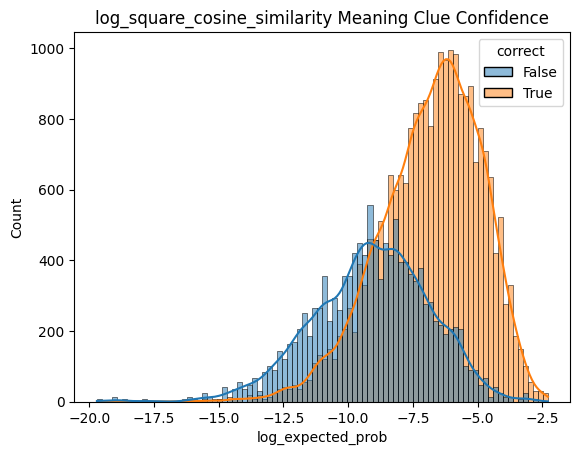

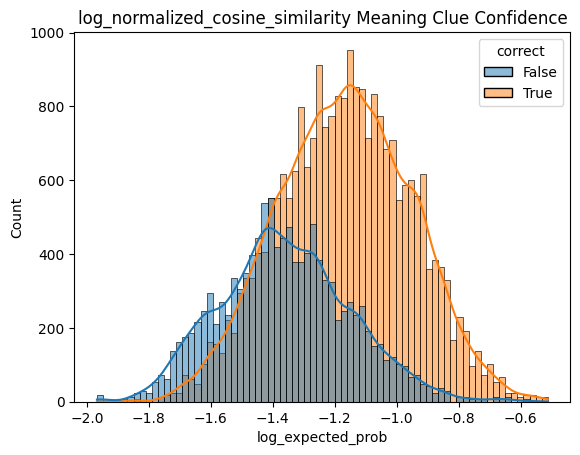

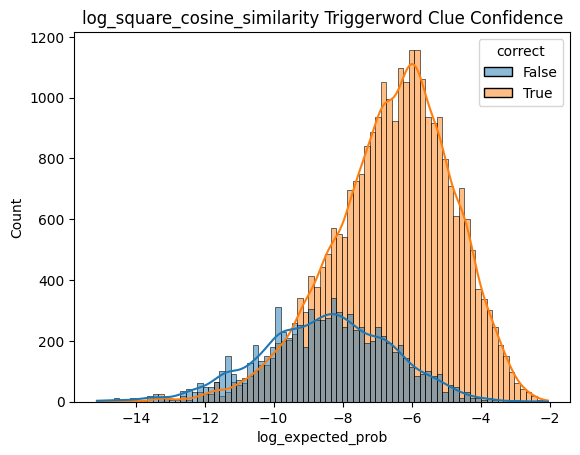

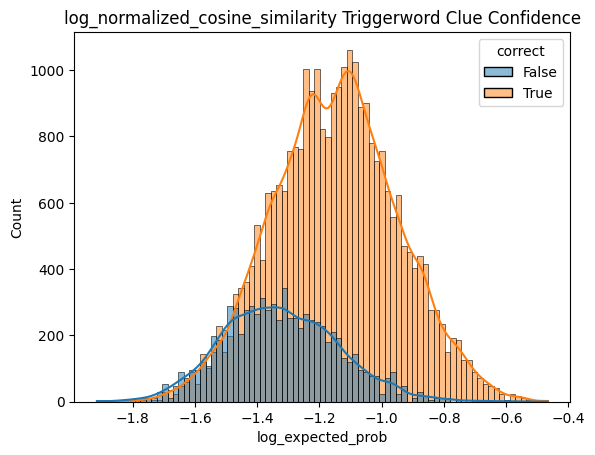

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

for strat_func, meaning_guesses_df in meaning_guesses.items():
    _, ax = plt.subplots()
    plot = sns.histplot(ax=ax, data=meaning_guesses_df, x="log_expected_prob", hue="correct", kde=True)
    plot.set(title=f'{strat_func.__name__} Meaning Clue Confidence')

for strat_func, triggerword_guesses_df in triggerword_guesses.items():
    _, ax = plt.subplots()
    plot = sns.histplot(ax=ax, data=triggerword_guesses_df, x="log_expected_prob", hue="correct", kde=True)
    plot.set(title=f'{strat_func.__name__} Triggerword Clue Confidence')

Fortunately, we observe that the guesser does not have a false sense of confidence. It assigns its incorrect guesses a significantly lower probability than it assigns its correct guesses.

The distributions are also not showing erratic behavior or an obvious pitfall, implying the guessing is working how we expect.

In [28]:
meaning_guessed_wrong = {}
for strat_func, meaning_guesses_df in meaning_guesses.items():
    meaning_guessed_wrong[strat_func] =  meaning_clue_df[meaning_guesses_df["correct"] == False]
    meaning_guessed_wrong[strat_func]["guessed_code_index"] = meaning_guesses_df["code_index_guess"][meaning_guesses_df["correct"] == False]
    meaning_guessed_wrong[strat_func]["correct_code_index"] = meaning_correct_code_index[meaning_guesses_df["correct"] == False]

triggerword_guessed_wrong = {}
for strat_func, triggerword_guesses_df in triggerword_guesses.items():
    triggerword_guessed_wrong[strat_func] =  triggerword_clue_df[triggerword_guesses_df["correct"] == False]
    triggerword_guessed_wrong[strat_func]["guessed_code_index"] = triggerword_guesses_df["code_index_guess"][triggerword_guesses_df["correct"] == False]
    triggerword_guessed_wrong[strat_func]["correct_code_index"] = triggerword_correct_code_index[triggerword_guesses_df["correct"] == False]

meaning_guessed_wrong[log_square_cosine_similarity].head()


/var/folders/5r/fmvyqtcd33111tp2chr8wmy40000gn/T/ipykernel_1281/1201352120.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meaning_guessed_wrong[strat_func]["guessed_code_index"] = meaning_guesses_df["code_index_guess"][meaning_guesses_df["correct"] == False]
/var/folders/5r/fmvyqtcd33111tp2chr8wmy40000gn/T/ipykernel_1281/1201352120.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meaning_guessed_wrong[strat_func]["correct_code_index"] = meaning_correct_code_index[meaning_guesses_df["correct"] == Fal

,keyword1,keyword2,keyword3,keyword4,clue1,clue2,clue3,guessed_code_index,correct_code_index
0,BUTTERFLY,PLUMBER,FOOT,BLOOD,throttle,electricians,leg,14.0,0
1,BUTTERFLY,PLUMBER,FOOT,BLOOD,throttle,electricians,ancestry,15.0,1
2,BUTTERFLY,PLUMBER,FOOT,BLOOD,throttle,leg,electricians,12.0,2
3,BUTTERFLY,PLUMBER,FOOT,BLOOD,throttle,leg,ancestry,13.0,3
4,BUTTERFLY,PLUMBER,FOOT,BLOOD,throttle,ancestry,electricians,17.0,4


We see that some of the mistakes the guesser is making are reasonable. The guesser guessed that "butterfly" and "leg" went together more well than "butterfly" and "throttle". In the context of the first guess, it might make sense to say "foot" goes with "throttle" and "butterfly" goes with "leg" just as much as the other way around.

There are 2 primary things to note. One is that the performance of our Guesser relies somewhat on the competence of the Encryptor. We observe that the Encrypto isn't taking into account that some of its choice words may make sense for multiple keywords, and result in a conflict.

The other thing to note is that our Guesser is having trouble with scale, as predicted. We see that it often sticks with a word that seems "most fit" without really scaling how fit it is to how common the word is. A different heuristic may help with this.